# Using python collecting real-world data by web scrapping realestate website and doing data wrangling.

__contributed by:__
>Name: **Rakesh Nain**

In any data science project one of the most asked questions is how to get the data, where is the data. I would say there is plenty of data around you, you just need to extract it. For example, on the internet, there are millions of petabytes of data available and most of it is free. All you need to know is how to extract it and make it useful for your organisation. I would say any type of organisation can make use of the free data available on the internet for their business gains. They can use web scraping to extract it.

For demonstrating web scrapping in this article I will be scraping data from domian.com. Domain.com is a real estate website. I will be scrapping the price, number of bedrooms, number of bathrooms, number of parking, address and location(latitude and longitude) of each house in Melbourne, Australia.

Before diving into python programming you need to know some basics about html.
All the web pages are written in HTML(Hyper Text Markup Language).
HTML is the standard markup language for creating Web pages
HTML describes the structure of a Web page
HTML elements tell the browser how to display the content
HTML elements label pieces of content such as "this is a heading", "this is a paragraph", "this is a link", etc.

A simple HTML document looks like this:

```
<!DOCTYPE html>
<html>
<head>
<title>Page Title</title>
</head>
<body>

<h1>This is a Heading</h1>
<p>This is a paragraph.</p>

</body>
</html>
```
Where,
- The <!DOCTYPE html> declaration defines that this document is an HTML5 document
- The `<html>` element is the root element of an HTML page
- The `<head>` element contains meta information about the HTML page
- The `<title>` element specifies a title for the HTML page (which is shown in the browser's title bar or in the page's tab)
- The `<body>` element defines the document's body, and is a container for all the visible contents, such as headings, paragraphs, images, hyperlinks, tables, lists, etc.
- The `<h1>` element defines a large heading
- The `<p>` element defines a paragraph

You can get this HTML document of any website by doing a right-click on a webpage and then selecting "View page source"(available in Microsoft Edge and Google Chrome). All the content on the webpage will be inside this HTML document in a well-structured format, all you need to do is extract the required data from this HTML document.

1. __Data Collection__

    There are various libraries available in Python to get this HTML document and parse it into the required format you want.

In [4]:
# sample code to get a HTML document and parse it into the required format you want

from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("https://www.domain.com.au/sale/melbourne-region-vic/")
bsobj = BeautifulSoup(html, "lxml")

In the above code, urlopen is extracting HTML document of given web page and BeautifulSoup is phrasing it into lxml format. lxml format is easy to understand, you can use another format you want such as json etc.

<img src="Screenshot (358).png" alt="Search result for melbourne houses on Domain.com" title="Domain.com" width="600" />

Search result for melbourne houses on Domain.comThe above screenshot showing "https://www.domain.com.au/sale/melbourne-region-vic/" URL result and it is showing all the properties available for selling in Melbourne but we need to find webpages for each Melbourne properties available on "https://www.domain.com.au/sale/melbourne-region-vic/"(this search result page). We can do it by extracting all the URLs available on this page and storing them into a list. One more thing to add here is that there are 50 pages for Melbourne house search on Domain.com and this is only 1st page so we need to go to every 50 pages and extract all the URLs for each advertised house in Melbourne. We need to apply the loop for 50 iterations, each iteration for each page.

In [5]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
# home url of domian.com australia
home_url = "https://www.domain.com.au"
# number of pages of search result are 50, so we need to 
page_numbers = list(range(50))[1:50]
# list to store all the urls of properties
list_of_links = []
# for loop for all 50 search(melbourne region) pages
for page in page_numbers:
 
    # extracting html document of search page
    html = urlopen(home_url + "/sale/melbourne-region-vic/?sort=price-desc&page=" + str(page))
    # parsing html document to 'lxml' format
    bsobj = BeautifulSoup(html, "lxml")
    # finding all the links available in 'ul' tag whos 'data-testid' is 'results'
    all_links = bsobj.find("ul", {"data-testid": "results"}).findAll("a", href=re.compile("https://www.domain.com.au/*"))
# inner loop to find links inside each property page because few properties are project so they have more properties inside their project page
    for link1 in all_links:
        # checking if it is a project and then performing similar thing I did above
        if 'project' in link1.attrs['href']:
            inner1_html = urlopen(link1.attrs['href'])
            inner1_bsobj = BeautifulSoup(inner1_html, "lxml")
            for link2 in inner1_bsobj.find("div", {"name": "listing-details__other-listings"}).findAll("a", href=re.compile("https://www.domain.com.au/*")):
                if 'href' in link2.attrs:
                    list_of_links.append(link2.attrs['href'])
        else:
            list_of_links.append(link1.attrs['href'])

You can simply copy and paste the above code and do some modifications according to your needs, and try to run. Or you can download my jupyter notebook.

Above I did a few different things:
- I used the search page which is sorted by price. I did this so that it will be easier to impute missing price of houses. I will explain it more in data wrangling part below.
- The Inner loop is used because few properties are not just properties, they are projects and each project have more properties URL links inside their page.

Now we have all the URLs of each property in Melbourne, Australia. Each URL is unique for each property in Melbourne. Our next step will be, go inside each URL and extract price, number of bedrooms, number of bathrooms, number of parking, address and location(latitude and longitude).

In [6]:
# removing duplicate links while maintaining the order of urls
abc_links = [] 
for i in list_of_links: 
    if i not in abc_links: 
        abc_links.append(i) 
        
# defining required regural expression for data extraction     
pattern = re.compile(r'>(.+)<!.*>(.+?)</span>.*')
pattern1 = re.compile(r'>(.+)<.')
pattern2 = re.compile(r'destination=(.+)" rel=.')
basic_feature_list = []
# loop to iterate through each url
for link in abc_links:
    
    # opening urls
    html = urlopen(link)
    
    # converting html document to 'lxml' format
    bsobj = BeautifulSoup(html, "lxml")
    
    # extracting address/name of property
    property_name = bsobj.find("h1", {"class": "css-164r41r"})
    
    # extracting baths, rooms, parking etc
    all_basic_features = bsobj.find("div", {"class": "listing-details__listing-summary-features css-er59q5"}).findAll("span", {"data-testid": "property-features-text-container"})
    
    # extracting property price
    property_price = bsobj.find("div", {"data-testid": "listing-details__summary-title"})
    
    # extracting latitudes and longitudes
    lat_long = bsobj.find("a", {"target": "_blank", 'rel': "noopener noreferer"})
    
    # dictionary to store temporary data
    basic_feature_dict = {}
    
    # few properties does not contain all the 4 features such as rooms, baths, parkings, area. So need to check
    # how many features they contain
    if len(all_basic_features) == 4:
        basic_feature_dict[pattern.findall(str(all_basic_features[0]))[0][1]] = pattern.findall(str(all_basic_features[0]))[0][0]
        basic_feature_dict[pattern.findall(str(all_basic_features[1]))[0][1]] = pattern.findall(str(all_basic_features[1]))[0][0]
        basic_feature_dict[pattern.findall(str(all_basic_features[2]))[0][1]] = pattern.findall(str(all_basic_features[2]))[0][0]
        basic_feature_dict[pattern.findall(str(all_basic_features[3]))[0][1]] = pattern.findall(str(all_basic_features[3]))[0][0]
        
    elif len(all_basic_features) == 3:
        basic_feature_dict[pattern.findall(str(all_basic_features[0]))[0][1]] = pattern.findall(str(all_basic_features[0]))[0][0]
        basic_feature_dict[pattern.findall(str(all_basic_features[1]))[0][1]] = pattern.findall(str(all_basic_features[1]))[0][0]
        basic_feature_dict[pattern.findall(str(all_basic_features[2]))[0][1]] = pattern.findall(str(all_basic_features[2]))[0][0]
        
    elif len(all_basic_features) == 2:
        basic_feature_dict[pattern.findall(str(all_basic_features[0]))[0][1]] = pattern.findall(str(all_basic_features[0]))[0][0]
        basic_feature_dict[pattern.findall(str(all_basic_features[1]))[0][1]] = pattern.findall(str(all_basic_features[1]))[0][0]
        
    elif len(all_basic_features) == 1:
        basic_feature_dict[pattern.findall(str(all_basic_features[0]))[0][1]] = pattern.findall(str(all_basic_features[0]))[0][0]
# putting 'none' if price is missing    
    if property_price is None:
        basic_feature_dict['price'] = None
        
    else:
        basic_feature_dict['price'] = pattern1.findall(str(property_price))[0]
        
    # putting 'none' if property name/address is missing       
    if property_name is None:
        basic_feature_dict['name'] = None
        
    else:
        basic_feature_dict['name'] = pattern1.findall(str(property_name))[0]
        
    # putting 'none' if latitude and logitude are missing        
    if lat_long is None:
        basic_feature_dict['lat'] = None
        basic_feature_dict['long'] = None
        
    else:
        basic_feature_dict['lat'] = pattern2.findall(str(lat_long))[0].split(',')[0]
        basic_feature_dict['long'] = pattern2.findall(str(lat_long))[0].split(',')[1]
# appending all the data into a list
    basic_feature_list.append(basic_feature_dict)

Now, the output of the above code gives us a list of dictionaries with all the available extracted data. In the below code we will be converting it into many individual lists because we have to do little more cleaning and extraction of above-extracted data and it will be easier to do in lists.

In [7]:
# creating empty lists
beds_list = []
baths_list = []
parking_list = []
area_list = []
name_list = []
lat_list = []
long_list = []
price_list = []
# interating through list created above with data
for row in basic_feature_list:
    
    # checking if the row cointains 'Beds', 'Bed' or nothing
    if 'Beds' in row:
        beds_list.append(row['Beds'])
    elif 'bed' in row:
        beds_list.append(row['Bed'])
    else:
        beds_list.append(None)
        
    # checking if the row cointains 'Baths', 'Bath' or nothing    
    if 'Baths' in row:
        baths_list.append(row['Baths'])
    elif 'Bath ' in row:
        baths_list.append(row['Bath'])
    else:
        baths_list.append(None)
        
    # checking if the row cointains 'Parking', '-' or nothing     
    if 'Parking' in row and row['Parking'] != '−':
        parking_list.append(row['Parking'])
    else:
        parking_list.append(None)
        
    # checking if the row cointains ' ', or nothing. Because empty space (i.e. ' ') reprsents area  
    if ' ' in row:
        area_list.append(row[' '])
    else:
        area_list.append(None)
# checking if the row cointains 'name' that is address of property         
    if 'name' in row:
        name_list.append(row['name'])
    else:
        name_list.append(None)
    
    # checking if the row cointains 'price'         
    if 'price' in row:
        price_list.append(row['price'])
    else:
        price_list.append(None)        
    
    # checking if the row cointains 'lat' that is lattitude of property         
    if 'lat' in row:
        lat_list.append(row['lat'])
    else:
        lat_list.append(None)  
        
    # checking if the row cointains 'long' that is lattitude of property             
    if 'long' in row:
        long_list.append(row['long'])
    else:
        long_list.append(None)

Now, we have all the data in list format.

2. __Data Wrangling__

    Few people do not want to show the price of the property so they do not put price in their property advertisement. Some times they do not put anything in the price column and sometimes they put something like 'contact dealer' or 'after inspection price' or something else. And also some people do not put directly price they put a range of price or price with some extra text before the price or after the price or both. So we need to handle all these situations and extract only the price and if the price is not given then put 'none' their. Below code is doing the same.

In [8]:
import random
# creating a new empty price list
actual_price_list = []
# defining some regural expressions, they will be used to extract price of properties
pattern1 = re.compile(r'\$\s?([0-9,\.]+).*\s?.+\s?\$\s?([0-9,\.]+)')
pattern2 = re.compile(r'\$([0-9,\.]+)')
# interating through price_list
for i in range(len(price_list)):
    
    # check that a price is given or range of price is given
    
    if str(price_list[i]).count('$') == 1:
        b_num = pattern2.findall(str(price_list[i]))
        
        # checking length of string, if it is less than or equal to 5 then price is in millions so need to convert the price
        if len(b_num[0].replace(',', '')) > 5:
            actual_price_list.append(float(b_num[0].replace(',', '')))
        else:
            actual_price_list.append(float(b_num[0].replace(',', ''))*1000000)
        
    elif str(price_list[i]).count('$') == 2:
        a_num = pattern1.findall(str(price_list[i]))
        random_error = random.randint(0, 10000)
        
        # checking length of string, if it is less than or equal to 5 then price is in millions so need to convert the price
        if len(a_num[0][0].replace(',', '')) > 5 and len(a_num[0][1].replace(',', '')) > 5:
            
            # to take average price between two price range given
            avg_price = (float(a_num[0][0].replace(',', '')) + float(a_num[0][1].replace(',','')))/2
        else:
            avg_price = (float(a_num[0][0].replace(',', '')) + float(a_num[0][1].replace(',',''))/2)*1000000
            
        # adding or subtracting the amount from the average price by normally distributed generated random number
        avg_price = avg_price + random_error
        actual_price_list.append(avg_price)
    else:
        actual_price_list.append('middle_price')

There are alot of missing values in price because many people do not want to give or show house price on the website. Now we need to impute the missing price and I came up with a trick.

**The trick is that we sort houses by their price then all the houses with or without the shown price will be sorted. The sorting by the website is done using price given by the owners of the houses to the website but it is not shown on the website for users. This is why we extracted houses data from the website when website results are sorted by price.**

Let us understand it using an example, suppose there are 10 houses and price of two houses is missing but we can sort houses according to their price, so 1st we sort them according to their price then we see that price of house 4 and house 5 is missing so we will take mean of the price of house 3 and house 6. And then impute missing prices with that mean value. Similar kind of thing we will be doing in the below code.

In [9]:
# for loop to impute missing values at the start of list, because here we cannot take mean
for i in range(len(actual_price_list)):
    if actual_price_list[i] != 'middle_price':
        for a in range(i, -1, -1):
            actual_price_list[a] = actual_price_list[i]
        break
# here we will be taking mean and then add random number with same standard deviation normal distribution and then impute it
for i in range(len(actual_price_list)):
    if actual_price_list[i] == 'middle_price':
        for j in range(i, len(actual_price_list)):
            if actual_price_list[j] != 'middle_price':
                mid = (actual_price_list[i-1] + actual_price_list[j])/2
                if actual_price_list[j] > 12000000:
                    for k in range(i, j):
                        random_error = random.randint(-1000000, 1000000)
                        mid = mid + random_error
                        actual_price_list[k] = mid
                    i = j
                    break
                elif actual_price_list[j] > 5000000:
                    for k in range(i, j):
                        random_error = random.randint(-100000, 100000)
                        mid = mid + random_error
                        actual_price_list[k] = mid
                    i = j
                    break
                else:
                    for k in range(i, j):
                        random_error = random.randint(-10000, 10000)
                        mid = mid + random_error
                        actual_price_list[k] = mid
                    i = j
                    break
            elif j == len(actual_price_list)-1:
                for n in range(i, len(actual_price_list)):
                    random_error = random.randint(-1000, 1000)
                    a_price = actual_price_list[i-1]
                    a_price = a_price + random_error
                    actual_price_list[n] = a_price
                break

Creating Dataframe.

In [10]:
import pandas as pd

house_dict = {}
house_dict['Beds'] = beds_list
house_dict['Baths'] = baths_list
house_dict['Parking'] = parking_list
house_dict['Area'] = area_list
house_dict['Address'] = name_list
house_dict['Latitude'] = lat_list
house_dict['Longitude'] = long_list
house_dict['Price'] = actual_price_list
house_df = pd.DataFrame(house_dict)
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Beds       798 non-null    object 
 1   Baths      755 non-null    object 
 2   Parking    764 non-null    object 
 3   Area       627 non-null    object 
 4   Address    1054 non-null   object 
 5   Latitude   1054 non-null   object 
 6   Longitude  1054 non-null   object 
 7   Price      1054 non-null   float64
dtypes: float64(1), object(7)
memory usage: 37.1+ KB


'area' column have many null values which cannot be imputed so we will be deleting 'area' column.

In [11]:
house_df.drop('Area', axis=1, inplace=True)

Also converting beds, baths, parking string type into numeric type.

In [12]:
house_df["Beds"] = pd.to_numeric(house_df["Beds"])
house_df["Baths"] = pd.to_numeric(house_df["Baths"])
house_df["Parking"] = pd.to_numeric(house_df["Parking"])

Now perform some explanatory data analytics to find problems in the data and then solve those issues. For example use scatter plot to check outliers in the data or use histogram to see the distribution of data etc.

<AxesSubplot:xlabel='Beds', ylabel='Frequency'>

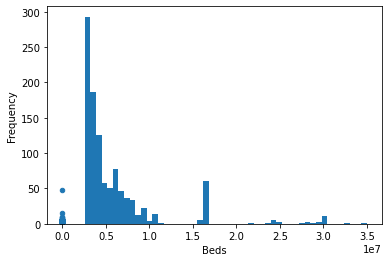

In [13]:
# scatter plot
house_df.plot.scatter(x='Beds',
                      y='Baths')
# histogram
house_df["Price"].plot.hist(bins = 50)

Data cleansing is an iterative process. The first step of the cleansing process is data auditing. In this step, we identify the types of anomalies that reduce the data quality.  Data auditing is about programmatically checking the data using some validation rules that are pre-specified, and then creating a report of the quality of the data and its problems. We often apply some statistical tests in this step for examining the data.
Data Anomalies can be classified at a high level into three categories:

1. **Syntactic Anomalies**: 
describe characteristics concerning the format and values used for representation of the entities. Syntactic anomalies such as: lexical errors, domain format errors, syntactical error and irregularities.
2. **Semantic Anomalies**: 
hinder the data collection from being a comprehensive and non-redundant representation of the mini-world. These types of anomalies include: Integrity constraint violations, contradictions, duplicates and invalid tuples
3. **Coverage Anomalies**: 
decrease the amount of entities and entity properties from the mini-world that are represented in the data collection. Coverage anomalies are categorized as: missing values and missing tuples

We give examples in this part of the auditing process that is applied to discover different anomalies in data.
***

__Missing values__

Source of missing values:

* Data Extraction: It is possible that there are problems with extraction process. In such cases, we should double-check for correct data with data guardians. Some hashing procedures can also be used to make sure that data extraction is correct. Errors at data extraction stage are typically easy to find and can be corrected easily as well.
* Data collection: These errors occur at time of data collection and are harder to correct. They can be categorized in four types:
>* Missing completely at random: This is a case when the probability of missing variable is same for all observations. For example: respondents of data collection process decide that they will declare their earning after tossing a fair coin. If an head occurs, respondent declares his / her earnings & vice versa. Here each observation has equal chance of missing value.
>* Missing at random: This is a case when variable is missing at random and missing ratio varies for different values / level of other input variables. For example: We are collecting data for age and female has higher missing value compare to male.
>* Missing that depends on unobserved predictors: This is a case when the missing values are not random and are related to the unobserved input variable. For example: In a medical study, if a particular diagnostic causes discomfort, then there is higher chance of drop out from the study. This missing value is not at random unless we have included “discomfort” as an input variable for all patients.
>* Missing that depends on the missing value itself: This is a case when the probability of missing value is directly correlated with missing value itself. For example: People with higher or lower income are likely to provide non-response to their earning.

According to the research and after performing EDA(explanatory data analytics) you can safely find out what type of missingness in your data. Our extracted data is Missing completely at random and data set is huge so I have deleted all the rows with any 'none' value.

In [14]:
import math

cleaned_house_df = house_df.dropna(how='any')

cleaned_house_df.reset_index(drop = True, inplace = True)
# radius of earth is 6378
r = 6378
dis_to_city = []
for i in range(len(cleaned_house_df)):
    
    lat1_n = math.radians(-37.818078)
    lat2 = math.radians(float(cleaned_house_df['Latitude'][i]))
    
    lon1_n = math.radians(144.96681)
    lon2 = math.radians(float(cleaned_house_df['Longitude'][i]))
    
    lon_diff_n = lon2 - lon1_n
    lat_diff_n = lat2 - lat1_n
    
    a_n = math.sin(lat_diff_n / 2)**2 + math.cos(lat1_n) * math.cos(lat2) * math.sin(lon_diff_n / 2)**2
    c_n = 2 * math.atan2(math.sqrt(a_n), math.sqrt(1 - a_n))
    
    dis_to_city.append(round(r*c_n, 4))
    
cleaned_house_df['distance_to_city'] = dis_to_city

<ipython-input-14-232efbd8dd03>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_house_df['distance_to_city'] = dis_to_city


The final step is to export Dataframe to any other tabular format file like excel file or CSV file etc.

In [19]:
# exporting to csv file
cleaned_house_df.to_csv('real_estate_data_csv.csv', index=False)
# exporting to excel file
cleaned_house_df.to_excel('real_estate_data_excel.xlsx', index=False)